# Import

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

import shap
import joblib
import pickle
import gc

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.pretraining import TabNetPretrainer
from torch.optim.lr_scheduler import ReduceLROnPlateau

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

RANDOM_STATE = 4158
CHUNKSIZE = 50000

with open(f"./dtypes.pkl", 'rb') as f:
    dtypes = pickle.load(f)

In [19]:
#matplotlib 한글깨짐 지원

path = "/home/sungwoopark/mine/NanumGothic.otf"
# if platform.system() == 'Darwin':
#     rc('font', family='AppleGothic')
# elif platform.system() == 'Windows':
#     font_name = font_manager.FontProperties(fname=path).get_name()
#     rc('font', family=font_name)
# else:
#     print('Unknown system...')
    
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)
rc('axes', unicode_minus=False)  

In [2]:
class F1Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True
    
    def __call__(self, y_true, y_score):
        y_score = (y_score[:, 1] > 0.5).astype(np.uint8)
        return f1_score(y_true, y_score)

# Data Load

In [3]:
## models
deep_pre = joblib.load("../Model/pretrainer_no_sampling.pkl")
deep_clf = joblib.load("../Model/clf_no_sampling_2.pkl")
cat = joblib.load("../Model/Cat_Optuna_model_0.48_withLog.pkl")
lgb = joblib.load("../Model/LGBM_Optuna_model_0.44_WithLog.pkl")

Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [7]:
def loaddata(fname:str, chunksize:int, dtype:dict=None, columns:list=None):  
    df = pd.DataFrame()
    for chunk in tqdm(pd.read_csv(fname, engine='python', low_memory=True, chunksize=chunksize, dtype=dtype)):
        df = pd.concat([df, chunk], axis=0)
        del chunk
        gc.collect()

    return df

In [14]:
train = loaddata("../Data/master_train_data.csv", chunksize=CHUNKSIZE, dtype=dtypes)
valid = loaddata("../Data/master_public_data.csv", chunksize=CHUNKSIZE, dtype=dtypes)

144it [05:54,  2.46s/it]
19it [00:40,  2.13s/it]


In [37]:
cat_feats = ['income_type', 'employment_type', 'houseown_type', 'purpose', 'personal_rehabilitation_yn', 
             'personal_rehabilitation_complete_yn', 'gender', 'bank_diversity', 'product_diversity', 'holiday', 
             'weekday', 'foreign', 'segment', 'bank_label', 'product_label']
cat_idxs = [i for i, col in enumerate(train.columns.values) if col in cat_feats]

for col in train.columns.values:
    if train[col].dtype == 'bool':
        train[col] = train[col].astype('uint8')
    if valid[col].dtype == 'bool':
        valid[col] = valid[col].astype('uint8')
    if test[col].dtype == 'bool':
        test[col] = test[col].astype('uint8')
        
for col in cat_feats:
    if train[col].min() != 0:
        train[col] -= train[col].min()
    if valid[col].min() != 0:
        valid[col] -= valid[col].min()
    if test[col].min() != 0:
        test[col] -= test[col].min()

In [29]:
X_train = train.drop('is_applied', axis=1)
y_train = train['is_applied']

X_valid = valid.drop('is_applied', axis=1)
y_valid = valid['is_applied']

In [30]:
column_eng = ['loan_limit', 'loan_rate', 'credit_score', 'yearly_income',
       'income_type', 'employment_type', 'houseown_type', 'desired_amount',
       'purpose', 'personal_rehabilitation_yn',
       'personal_rehabilitation_complete_yn', 'existing_loan_cnt',
       'existing_loan_amt', 'enter_birth', 'gender', 'k_lending_rate',
       'us_lending_rate', 'btc_price', 'btc_variance', 'eth_price',
       'eth_variance', 'lunc_price', 'lunc_variance', 'Close', 'Open', 'High',
       'Low', 'Volume', 'Change', 'Unemployment', 'Unemp_rate', 'CurrentDebtCSI', 'DebtProspectCSI',
       'ConsumerPsy', 'loanapply_insert_time_rank', 'loan_limit_avg_sub',
       'loan_rate_avg_sub', 'bank_diversity', 'product_diversity',
       'missing_value_cnt', 'working_year', 'working_month', 'age', 'holiday',
       'weekday', 'hour', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos',
       'foreign', 'event', 'loan_cnt', 'duration', 'visit', 'segment',
       'product_cnt', 'loan_limit_mean_x', 'loan_rate_mean_x',
       'loan_limit_min_x', 'loan_rate_min_x', 'loan_limit_max_x',
       'loan_rate_max_x', 'bank_label', 'loan_limit_min_y', 'loan_rate_min_y',
       'loan_limit_max_y', 'loan_rate_max_y', 'loan_limit_mean_y',
       'loan_rate_mean_y', 'product_label']

X_train.columns = column_eng
X_valid.columns = column_eng

# TabNet Pretrain Mask

In [ ]:
## 단계별로 학습에 어떤 feature에 집중했는지를 나타내는 mask
pretrain_explain_matrix, pretrain_masks = deep_pre.explain(valid.values)

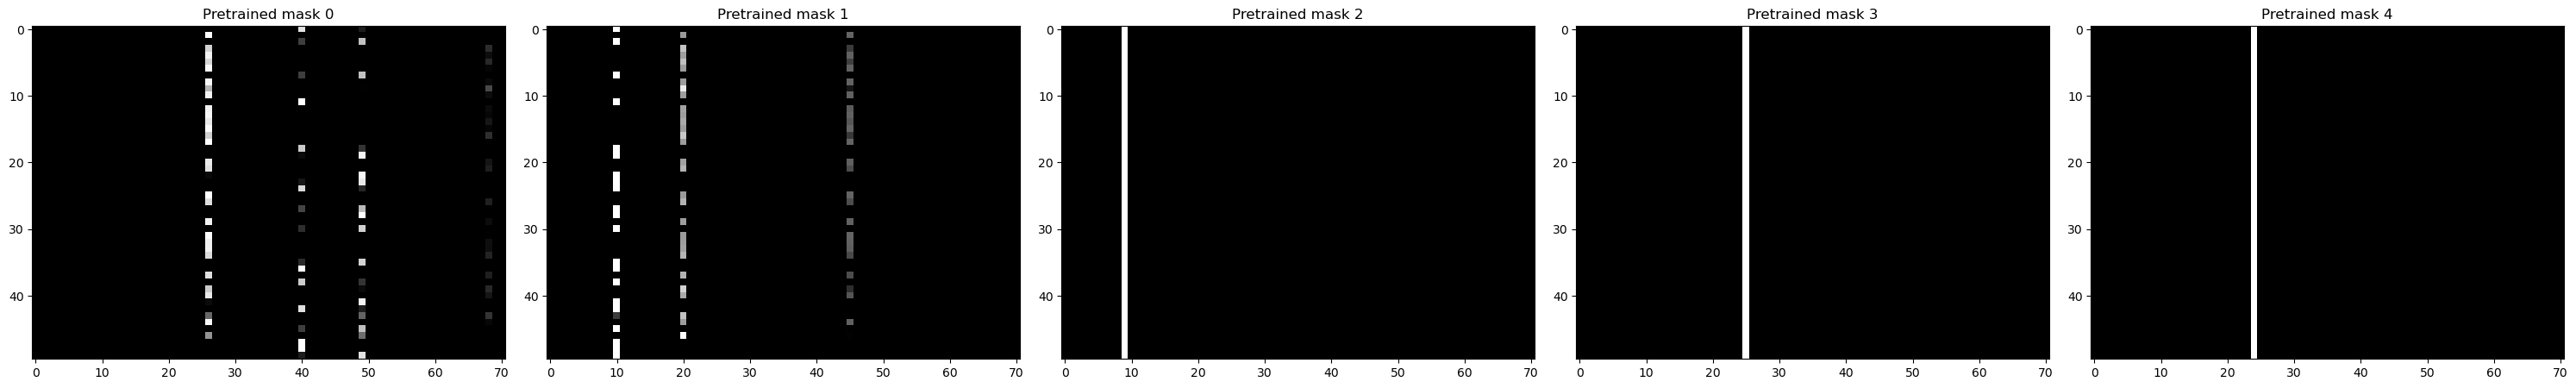

In [32]:
plt.figure(figsize=(30, 10))
for key in pretrain_masks:
    plt.subplot(int(f"{1}{len(pretrain_masks)}{key+1}"))
    plt.imshow(pretrain_masks[key][:50], cmap='gray')
    plt.title(f"Pretrained mask {key}")
plt.tight_layout()
plt.show()

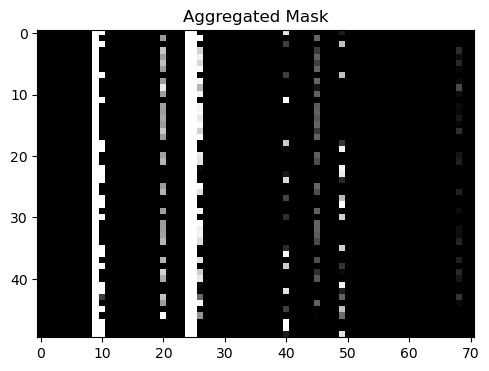

In [33]:
## 전체 mask
mask_agg = np.zeros(shape=pretrain_masks[0].shape)
for key in pretrain_masks:
    mask_agg += pretrain_masks[key]
mask_agg /= len(pretrain_masks)

plt.figure(figsize=(5, 10))
plt.imshow(mask_agg[:50], cmap='gray')
plt.title(f"Aggregated Mask")
plt.tight_layout()
plt.show()

# TabNet Classifier

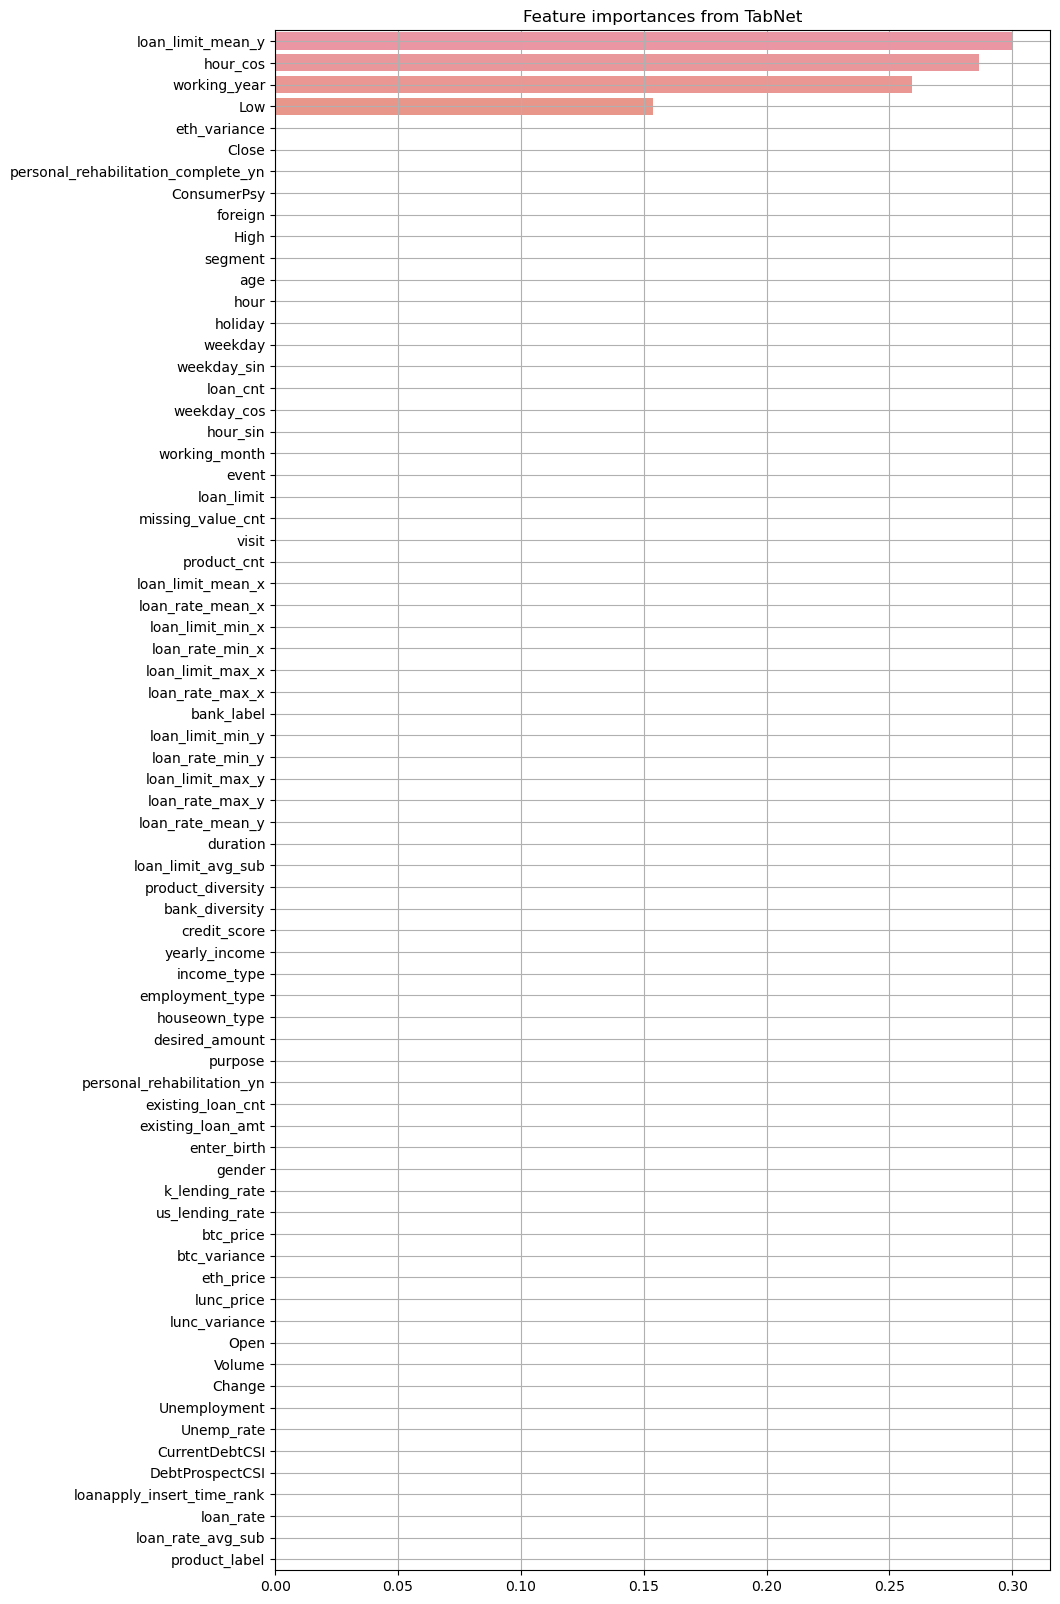

In [23]:
imp = pd.Series(data=deep_clf.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

plt.figure(figsize=(10, 20))
sns.barplot(x=imp, 
            y=imp.index)
plt.title("Feature importances from TabNet")
plt.grid(True)
plt.show()

# LGBM

## Feature Importances

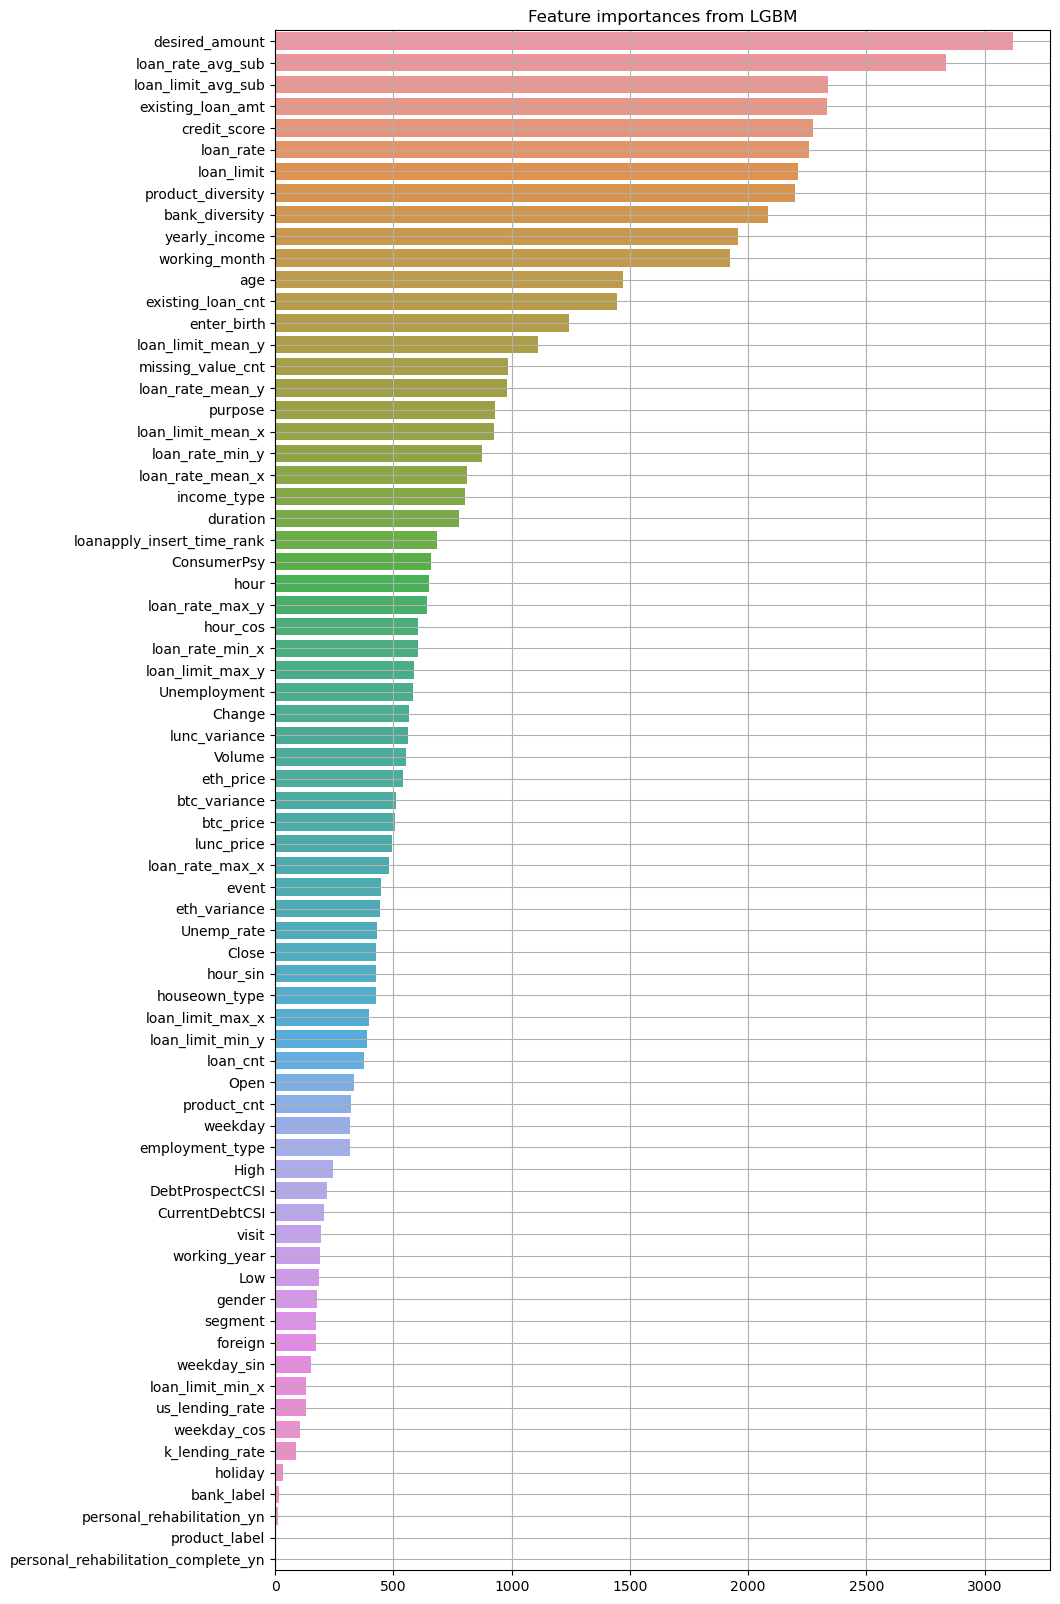

In [24]:
lgb_imp = pd.Series(data=lgb.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

plt.figure(figsize=(10, 20))
sns.barplot(x=lgb_imp, 
            y=lgb_imp.index)
plt.title("Feature importances from LGBM")
plt.grid(True)
plt.show()

## SHAP

In [ ]:
explainer = shap.TreeExplainer(lgb) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(test) # Shap Values 계산

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)

In [ ]:
shap.summary_plot(shap_values, test)

In [ ]:
shap.plots.waterfall(shap_values)

In [ ]:
shap.plots.force(shap_values)

# CatBoost

## Feature Importances

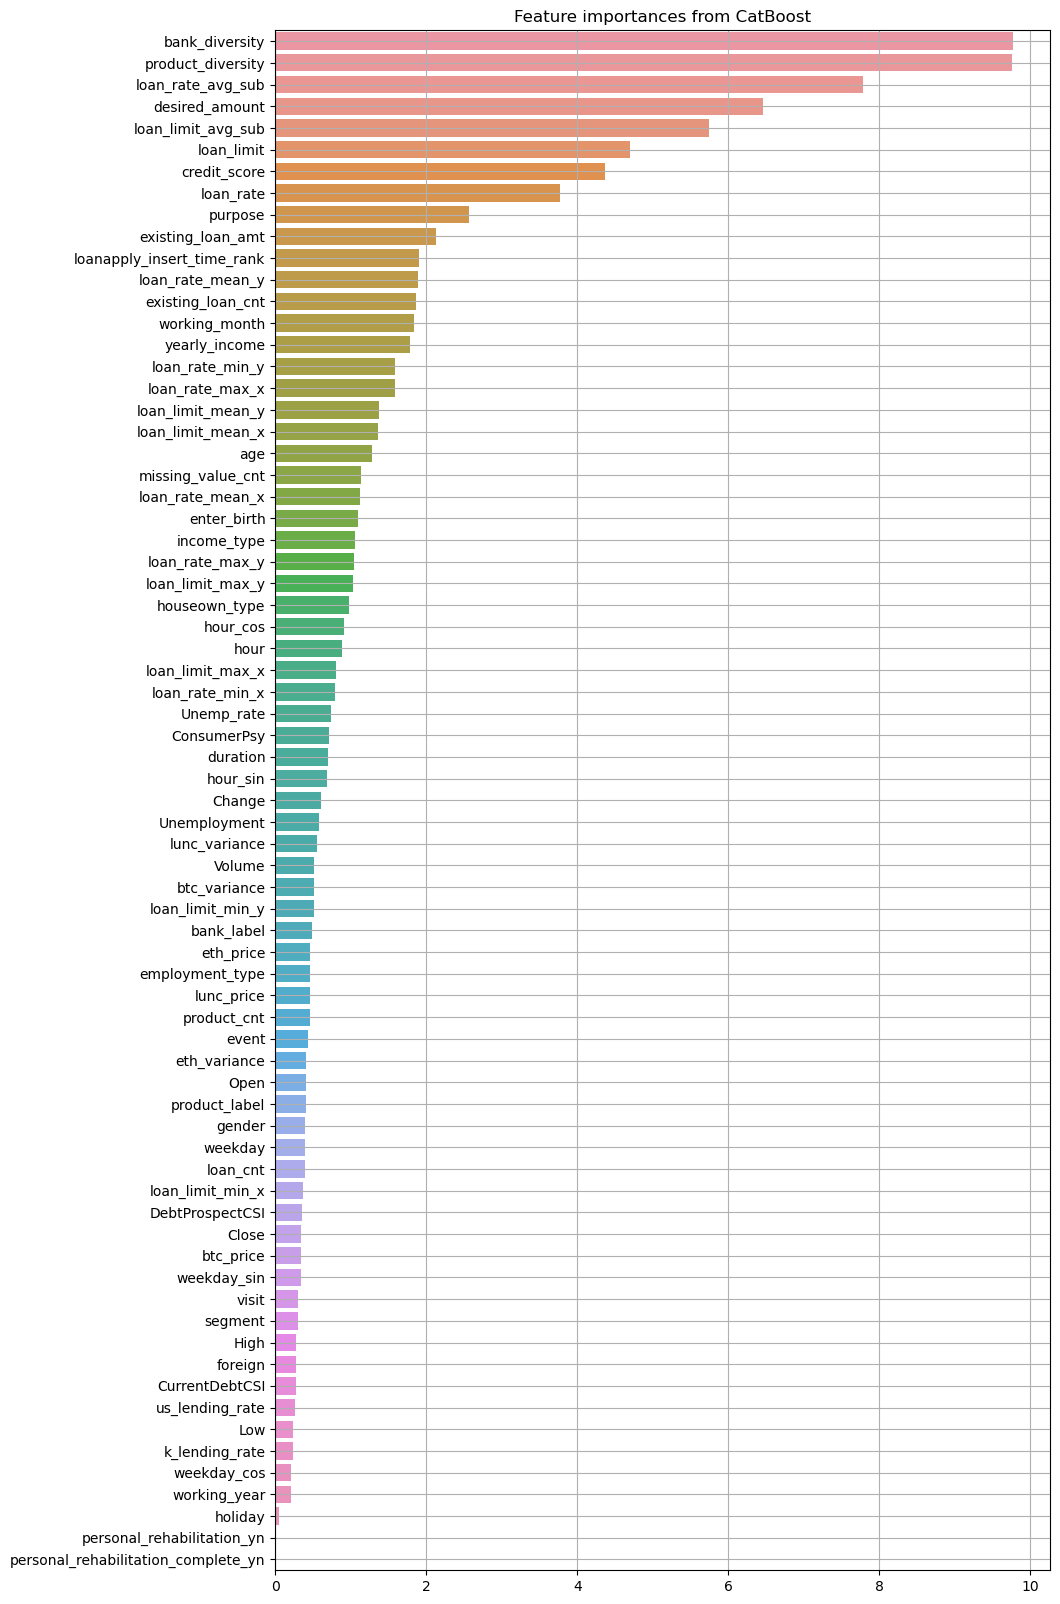

In [25]:
cat_imp = pd.Series(data=cat.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

plt.figure(figsize=(10, 20))
sns.barplot(x=cat_imp, 
            y=cat_imp.index)
plt.title("Feature importances from CatBoost")
plt.grid(True)
plt.show()

## SHAP

In [ ]:
explainer = shap.TreeExplainer(cat) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(test) # Shap Values 계산

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)

In [ ]:
shap.summary_plot(shap_values, test)

In [ ]:
shap.plots.waterfall(shap_values)

In [ ]:
shap.plots.force(shap_values)